## Sentiment Analysis on the IMDB dataset using gpt-3.5-turbo

#### Imports

In [6]:
import pandas as pd
from datasets import  load_dataset
import openai
import os
from tenacity import retry, stop_after_attempt, wait_random_exponential
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

#### Function definitions

In [7]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(3))
def review_classifier_gpt35(text: str) -> str:
    """
    Classifies whether a movie review is positive or negative,
    using Openai's gpt-3.5-turbo model.

    Args:
    text: str
        The review string
    response_text: list
        The predicted labels
    """
    messages = [
        {"role": "user",
         "content": f"""Analyze the following movie review and determine if the sentiment is: positive or negative.
                                        Return answer in single word as either positive or negative: {text}"""}
        ]

    response = openai.ChatCompletion.create(
                      model="gpt-3.5-turbo",
                      messages=messages,
                      max_tokens=1,
                      n=1,
                      stop=None,
                      temperature=0.1)

    response_text = response.choices[0].message.content.strip().lower()

    return response_text


def compute_metrics(true_labels: list,
                    predicted_labels: list) -> dict:
    """
    Computes classification eval metrics

    Args:
    true_labels: list
        The ground truth labels
    predicted_labels: list
        The predicted labels
    Returns:
    metrics_dict: dict
        The classification metrics
    """
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)

    metrics_dict = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy
    }
    return metrics_dict


def print_eval_metrics(metrics: dict) -> None:
    """Prints the Classification eval metrics"""
    print(f"The precision score is:  {metrics['precision']:.2f}")
    print(f"The recall score is:  {metrics['recall']:.2f}")
    print(f"The f1_score score is:  {metrics['f1_score']:.2f}")
    print(f"The accuracy score is:  {metrics['accuracy']:.2f}")
    pass


#### Load dataset and openai key

In [8]:
imdb = load_dataset("imdb")
openai.api_key = os.environ.get('OPENAI_API_KEY')

#### Select a sample for testing

In [9]:
n_samples = 7
test_df = pd.DataFrame(imdb['test']).sample(n_samples, random_state=42)

In [10]:
test_df

,text,label
6868,I could not believe how terrible and boring th...,0
24016,I rented Boogie Nights last week and I could t...,1
9668,"First off, this movie is not near complete, my...",0
13640,I watched this mini in the early eighties. Sam...,1
14018,This movie was never intended as a big-budget ...,1
7488,I thought this was an extremely bad movie. The...,0
5804,This was one of the biggest pieces of crap I h...,0


#### Apply classifier on test dataset

In [11]:
test_df['pred'] = test_df['text'].apply(review_classifier_gpt35)

In [13]:
test_df

,text,label,pred
6868,I could not believe how terrible and boring th...,0,negative
24016,I rented Boogie Nights last week and I could t...,1,positive
9668,"First off, this movie is not near complete, my...",0,negative
13640,I watched this mini in the early eighties. Sam...,1,positive
14018,This movie was never intended as a big-budget ...,1,positive
7488,I thought this was an extremely bad movie. The...,0,negative
5804,This was one of the biggest pieces of crap I h...,0,negative


#### Transform predictions column and store dataset

In [15]:
test_df.loc[test_df['pred'] == 'negative', 'pred'] = 0
test_df.loc[test_df['pred'] == 'positive', 'pred'] = 1
test_df['pred'] = test_df['pred'].astype(np.int64)
test_df.to_csv('predictions.csv', index=True)
print("Stored results.")


Stored results.


In [16]:
test_df

,text,label,pred
6868,I could not believe how terrible and boring th...,0,0
24016,I rented Boogie Nights last week and I could t...,1,1
9668,"First off, this movie is not near complete, my...",0,0
13640,I watched this mini in the early eighties. Sam...,1,1
14018,This movie was never intended as a big-budget ...,1,1
7488,I thought this was an extremely bad movie. The...,0,0
5804,This was one of the biggest pieces of crap I h...,0,0


#### Compute Metrics

In [17]:

metrics = compute_metrics(true_labels=test_df['label'].to_list(), 
                          predicted_labels=test_df['pred'].to_list())




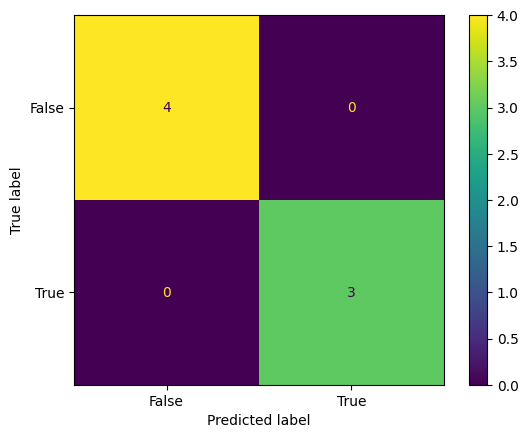

In [18]:
conf_matrix = confusion_matrix(y_true=test_df['label'].values, 
                               y_pred=test_df['pred'].values)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                                    display_labels=[False, True])
cm_display.plot()
plt.show()

In [22]:
import tiktoken
df = pd.DataFrame(imdb['test'])
encoding = tiktoken.get_encoding("cl100k_base")
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
df["tokens"] = df['text'].apply(encoding.encode)
df["n_tokens"] = df['tokens'].apply(len)